In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 1008


D:\Programmer\Anaconda\lib\site-packages\IPython\nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 29

## Student 1 
### Name : Mingyu Gao
### ID : 5216281

## Student 2
### Name : Yuhang Tian
### ID : 5219728

## Readme
The libraries we installed include three types:
- basic data process: numpy , pandas , ipython 
- machine learning: scikit_learn , imblearn 
- visualization: matplotlib , seaborn , jupyterthemes, matplotlib-venn

Readers can get the same dependencies with the command - pip install -r requirements.txt. 

## Load Library

In [2]:
from jupyterthemes import jtplot
import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
from matplotlib_venn import venn2 
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

jtplot.style('grade3')

## Load Data
Loading data and have a brief look.

In [3]:
# #Step 1: Loading the raw data file into our initial dataframe - df 
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [4]:
# Step 2: Printing each kind of transaction's number and proportion 
type_name, type_count = np.unique(df['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df),4))+'%)')

Chargeback: 345 (0.12%)
Refused: 53346 (18.37%)
Settled: 236691 (81.51%)


## Data Preporcessing
Includes deleting 'refused' category and encoding.

### Delete Refused Catagory

In [5]:
# As we are going to classify fraud and benign cases, 'refused' catagory are meaningless.
df_new = df[df['simple_journal'] != 'Refused'].copy()
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df_new),4))+'%)')

Chargeback: 345 (0.15%)
Settled: 236691 (99.85000000000001%)


### Data Encoding

In [6]:
# first encoding four features
# 1.label
df_new['label'] = df['simple_journal'].apply(
    lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['creationdate'] = df_new['creationdate'].dt.date
date_enc = LabelEncoder()
date_enc.fit(df_new['creationdate'])
df_new['date'] = date_enc.transform(df_new['creationdate'])

# 3.converting different currency to a homogeneous value - measured in euros
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}


def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100


df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(
    amount_to_euro, axis=1)

# 4. aggregation for cvcresponse code
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(
    lambda x: 3 if (x >= 3 and x < 6) else x)

# encoding for other features
# original features' names
col_ori = ['txvariantcode', 'issuercountrycode', 'accountcode', 'shopperinteraction',
           'shoppercountrycode']
# new features' names
col_new = ['txCode', 'issuerCountry', 'account', 'interaction',
           'shopperCountry']
label_encoder = LabelEncoder()
for col in range(0, len(col_ori)):
    df_new[col_new[col]] = label_encoder.fit_transform(
        df_new[col_ori[col]].astype(str))
# encoding for other features that do not need rename
column_list = [
 'bin',
#  'shoppercountrycode',
 'cardverificationcodesupplied',
 'mail_id',
 'ip_id',
 'card_id',
 'date']
for col in column_list:
    df_new[col] = label_encoder.fit_transform(df_new[col].astype(str))

## Visualization task
By visualizing the data, we can obtain a preliminary understanding of the difference of fraud and benign cases. 

In [7]:
# Step 1: redefining fraud and benign data after encoding and dropping a few columns
df_fraud = df_new[df_new['label'] == 1]
df_benign = df_new[df_new['label'] == 0]

### Plot visulations 

#### Boxplot - Amount
Boxplot is a method for graphically depicting groups of numerical data through their quartiles. It is clear to see the distribution of different features in fraud and benign cases. Amount represents the money of each transaction in euros. 

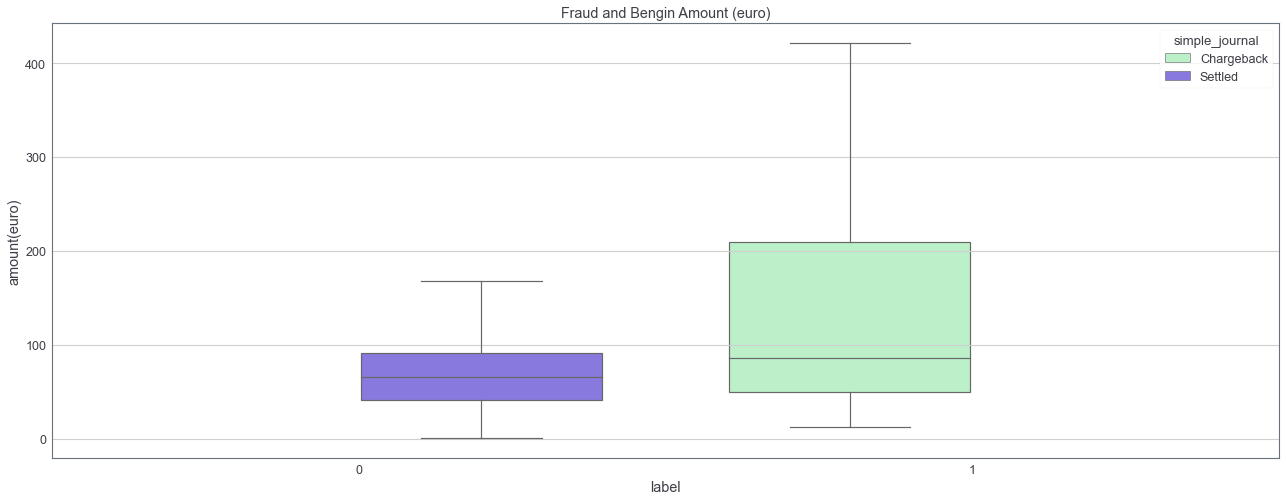

In [8]:
# setting the plot format
colors = ['#B3F9C5', '#7b68ee']
figure, (ax) = plt.subplots(1, figsize=(22, 8))
ax = sns.boxplot(x='label', y='euroAmount', hue='simple_journal', data=df_new,
                 showfliers=False, palette=colors
                 )
ax.set(xlabel='label', ylabel='amount(euro)')
plt.title('Fraud and Bengin Amount (euro)')
# plt.savefig('./figures/amountBoxplot.pdf', dpi=1200)
plt.show()

#### Histogram - txCode/issuerCountry/account/cvcRes
Histogram shows the distribution of a feature in two kinds of cases. 

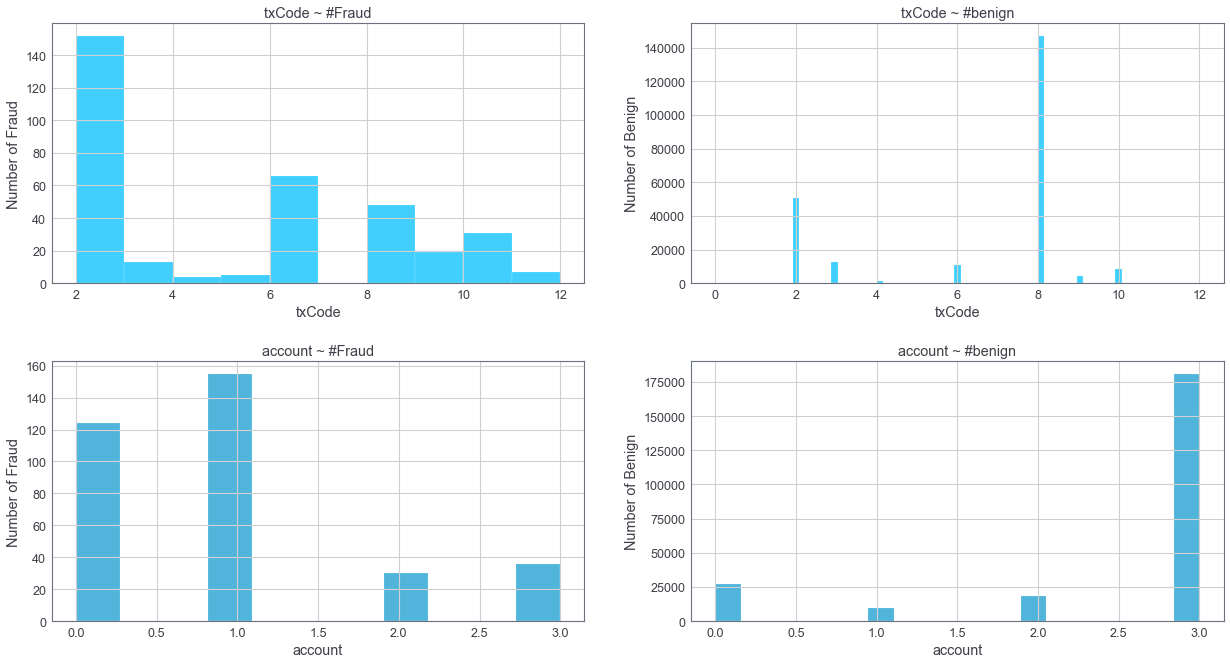

In [9]:
# setting plot format
plt.figure(figsize=(21, 11))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# histogram of txCode
plt.subplot(221)
sns.histplot(x='txCode', data=df_fraud, color='#00bfff')
plt.ylabel('Number of Fraud')
plt.title('txCode ~ #Fraud')
plt.subplot(222)
sns.histplot(x='txCode', data=df_benign, color='#00bfff')
plt.ylabel('Number of Benign')
plt.title('txCode ~ #benign')
# histogram of accountcode
plt.subplot(223)
sns.histplot(x='account', data=df_fraud, color='#179ccf')
plt.ylabel('Number of Fraud')
plt.title('account ~ #Fraud')
plt.subplot(224)
sns.histplot(x='account', data=df_benign, color='#179ccf')
plt.ylabel('Number of Benign')
plt.title('account ~ #benign')
# plt.savefig('./figures/txCode_account.pdf', dpi=1200)
plt.show()

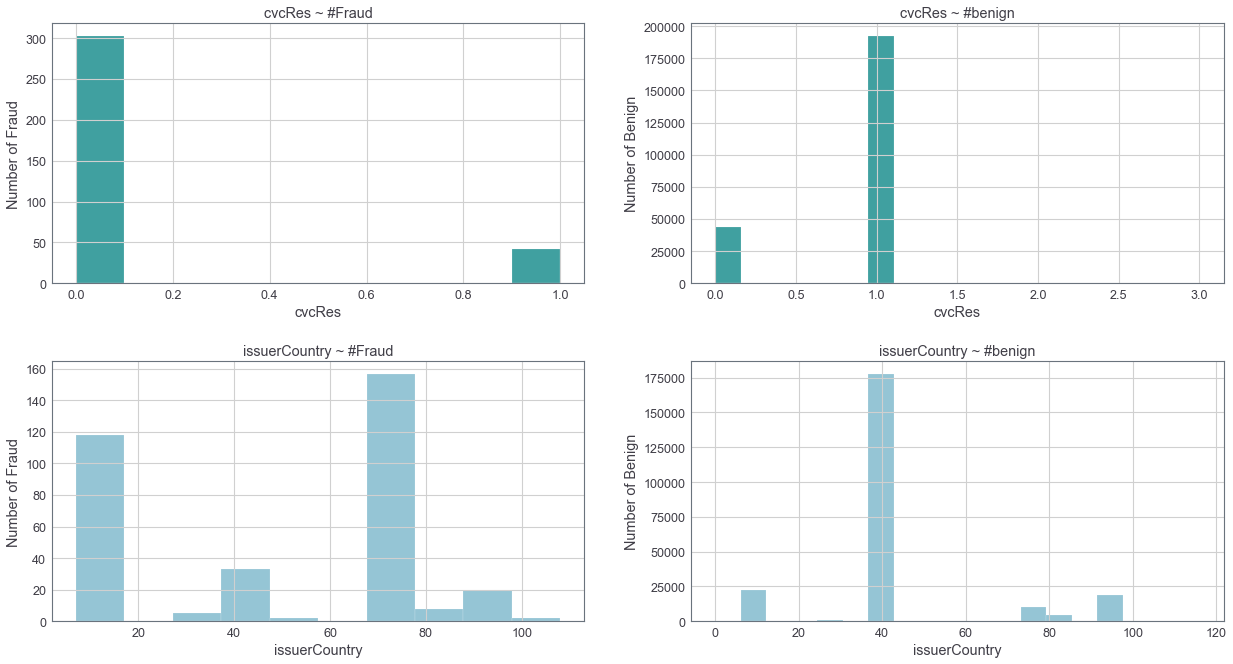

In [10]:
plt.figure(figsize=(21, 11))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# histogram of cvcresponsecode
plt.subplot(221)
sns.histplot(x='cvcRes', data=df_fraud, color='#008080')
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')
plt.subplot(222)
sns.histplot(x='cvcRes', data=df_benign, color='#008080')
plt.ylabel('Number of Benign')
plt.title('cvcRes ~ #benign')
# histogram of issuercountry
plt.subplot(223)
sns.histplot(x='issuerCountry', data=df_fraud, color='#72b2c7')
plt.ylabel('Number of Fraud')
plt.title('issuerCountry ~ #Fraud')
plt.subplot(224)
sns.histplot(x='issuerCountry', data=df_benign, color='#72b2c7')
plt.ylabel('Number of Benign')
plt.title('issuerCountry ~ #benign')
# plt.savefig('./figures/cvcRes_issuerCountry.pdf', dpi=1200)
plt.show()

#### Describe the visualizations and provide relavant explanations of features and relations.
1. The first figure shows that the amounts in Euro of malicious samples distribute in larger values.
2. Fraud transactions' tax codes concentrate around the value 2 when benign transactions' tax codes are mainly around 8.
3. Fraud ones happen in the accounts with 0 or 1 while benign ones tend to aggregate in the accounts with 3. 
4. The histograms of cvcresponsecode shows that the CVC response code of malicious transactions are mainly 0 while those of benign transactions are always 1. 
5. The last histogram shows that fraud mainly happens in MX, AU and GB.

## Imbalance task - Mingyu Gao
This part aims at addressing the under-sampling problem of raw data.
1. designing the smote algorithm to generate samples based on its k nearest neighbours
2. applying smoting for three classifiers - Random Forest, Gussian NB and Decision Tree
3. drawing ROC curves for smoted and unsmoted data
4. analysing their performace

In [11]:
# a dataframe copy that's used in smoting 
df_unsmote = df_new.copy()

In [12]:
# delete uncoded features
df_unsmote = df_unsmote.drop(['txid', 'txvariantcode', 'cvcresponsecode', 'shoppercountrycode',
 'bookingdate', 'issuercountrycode','amount', 'shopperinteraction',
 'simple_journal','creationdate', 'accountcode','currencycode'], axis ='columns')

In [13]:
df_unsmote.head()

,bin,cardverificationcodesupplied,mail_id,ip_id,card_id,label,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry
0,1998,1,187702,7386,73358,1,0,27.01512,0,2,76,1,1,98
1,2364,1,834,194109,44739,1,1,18.71881,0,2,76,1,1,98
2,1965,1,119287,189655,122802,1,1,62.49331,0,2,76,1,1,98
3,2374,1,173561,8254,70712,1,35,45.81731,0,2,76,1,1,98
4,1301,1,70647,196247,208481,1,90,37.47931,0,6,76,1,1,98


In [14]:
# obtain the labels and features of data
df_unsmote_label = df_unsmote['label'].copy() # all labels
df_unsmote_feature = df_unsmote.drop(['label'], axis ='columns') # all features

In [15]:
# splitting train_set and test_set at the rate of 80% and 20%
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    df_unsmote, test_size=0.2, random_state=42)
print("Number of rows in train_set " + str(len(train_set)))
print("Number of rows in test_set " + str(len(test_set)))

Number of rows in train_set 189628
Number of rows in test_set 47408


In [16]:
# split fraud and benign cases for smoting
fraud_data = train_set.loc[train_set['label'] == 1]
benign_data = train_set.loc[train_set['label'] == 0]
print("Number of rows in trainset_fraud_data " + str(len(fraud_data)))
print("Number of rows in trainset_benign_data " + str(len(benign_data)))

Number of rows in trainset_fraud_data 270
Number of rows in trainset_benign_data 189358


In [17]:
# deleting labels in fraud cases
fraud_data = fraud_data.drop(['label'], axis ='columns')

In [18]:
# spliting x and y axis for trainset and testset for classifier
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(df_unsmote_feature, df_unsmote_label, test_size=0.2, random_state=42)

### Print ROC curves
This part we design the function of drawing ROC curves - a graphical plot that illustrates the diagnostic ability of a binary classifier.

In [19]:
# function for drawing ROC
from sklearn.metrics import roc_curve, roc_auc_score
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    # train set for training models
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    return fpr, tpr, auc

### Implementing smote function

In [20]:
# building smote
from sklearn.neighbors import NearestNeighbors
import random
def smote(minority_for_smoting, k):
    '''
    minority_for_smoting: pandas dataframe
    k: the sampling rate
    
    return: smoted dataframe 
    '''
# k - sampling rate
    # T - Number of minority class samples
    T = len(minority_for_smoting)
    # cols - Column number of minority class samples
    n_features = len(minority_for_smoting.columns)
    # find the nearest k + 1 neighbours
    # number of neighbours > sampling rate
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm = 'auto').fit(minority_for_smoting)
    # distance : Array representing the lengths to points
    # indices: Indices of the nearest points in the population matrix
    distances, indices = nbrs.kneighbors(minority_for_smoting)
    nnarray = []
    data_array = [i for i in range(0,T * k)]
    # generating a matric for storing synthetic samples
    synthetic = pd.DataFrame(np.nan, index = data_array, columns = minority_for_smoting.columns)
    n = 0
    for i in range(len(indices)):
        # nnarray: storing the k+1 nearest neighbours
        for index in indices[i]:
            if index != i:
                nnarray.append(index)
        # choose a neighbour from the nearest k neighbours
        for k in nnarray:
            for m in range(0,n_features):
                # calculating the difference between the sample[k] to its neighbour [i]
                diff = np.subtract(minority_for_smoting.iloc[k, m], minority_for_smoting.iloc[i, m], dtype = np.float32)               
                # generating a new sample
                gap = random.uniform(0,1)
                synthetic.iloc[n, m] = minority_for_smoting.iloc[i, m] + (gap * diff)
            n += 1
        nnarray = []   
    smoted_data = minority_for_smoting.append(synthetic, ignore_index = True)    
    return smoted_data

In [21]:
# implement smote by ourselves to enlarge the fraud cases five times
smoted_fraud = smote(fraud_data,5)
print(str(len(smoted_fraud))) # check the new fraud cases

1620


In [22]:
# add labels to the smoted fraud cases
smoted_fraud["label"] = np.ones(len(smoted_fraud)) # add labels for the smoted ones
smoted_fraud.head() 

,bin,cardverificationcodesupplied,mail_id,ip_id,card_id,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry,label
0,1965.0,1.0,36120.0,186037.0,140354.0,3.0,83.33831,0.0,2.0,76.0,1.0,1.0,98.0,1.0
1,1052.0,1.0,139536.0,188243.0,128963.0,14.0,246.96595,0.0,10.0,7.0,0.0,1.0,8.0,1.0
2,2032.0,1.0,153807.0,38930.0,134360.0,59.0,218.09980,0.0,2.0,7.0,0.0,1.0,8.0,1.0
3,1504.0,1.0,120226.0,181227.0,35124.0,82.0,279.03945,0.0,6.0,7.0,0.0,1.0,8.0,1.0
4,940.0,1.0,31164.0,101287.0,39450.0,19.0,36.72333,1.0,8.0,40.0,3.0,1.0,47.0,1.0


In [23]:
# merge smoted fraud cases and benign cases
frames = [smoted_fraud, benign_data]
smoted_trainset = pd.concat(frames, sort=False)
print("length of merged: " + str(len(smoted_trainset)))

length of merged: 190978


In [24]:
# spliting smoted labels and features for the following three classfier
smoted_labels = smoted_trainset['label'].copy()  # smoted train set's abels
smoted_features = smoted_trainset.drop(['label'], axis ='columns') # smoted train set's features

### classifier
To see the effect of smoting, we apply three binary classifers for test set.

In [25]:
# 1. Random Forest
from sklearn.ensemble import RandomForestClassifier
## constructing Random Forest classifier
clf1 = RandomForestClassifier(n_estimators= 200, max_depth=10) 

Unsmoted AUC = 0.9424136789695703 Smoted AUC = 0.9423615659265205


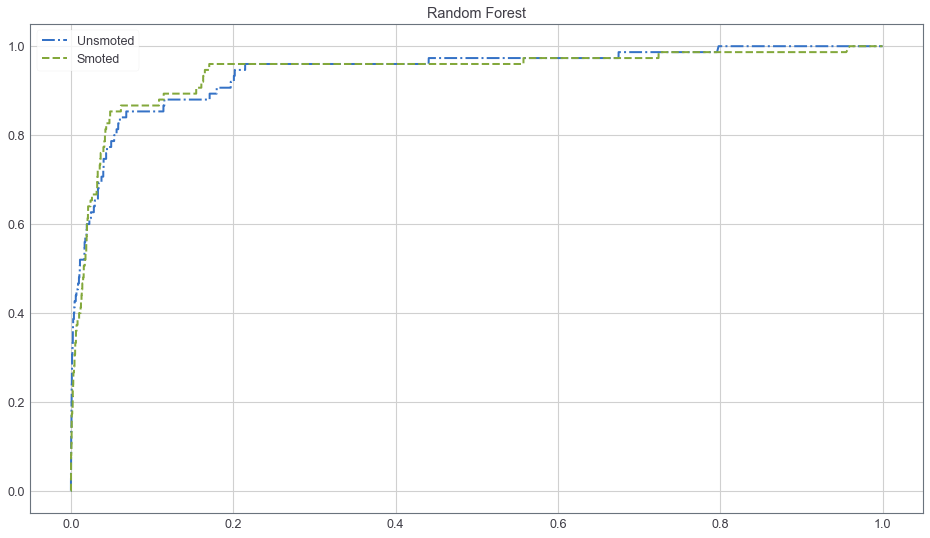

In [26]:
## plot format
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf1, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Random Forest")
plt.show()

In [27]:
# 2. Gussian NB
from sklearn.naive_bayes import GaussianNB
## constructing classifier
clf2 = GaussianNB()

Unsmoted AUC = 0.8469890633032627 Smoted AUC = 0.8471949802463398


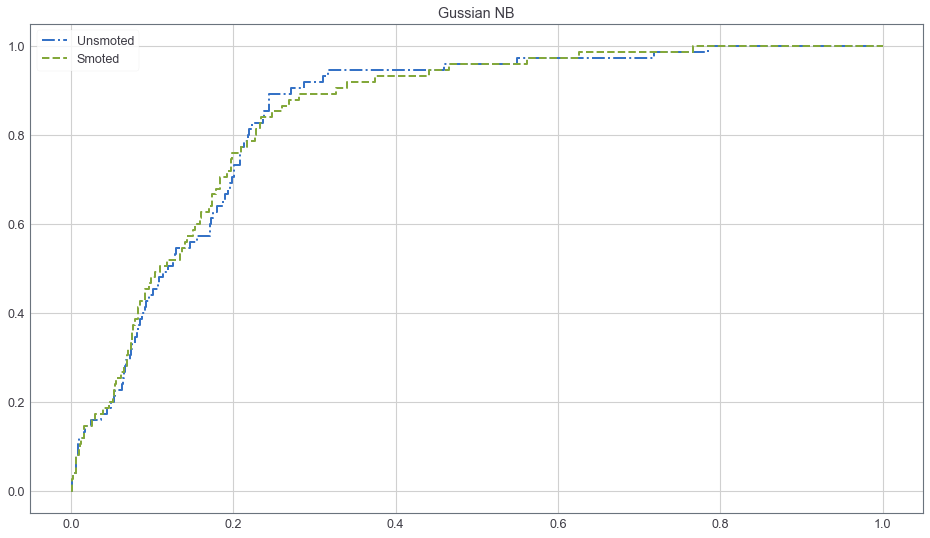

In [28]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf2, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Gussian NB")
plt.show()

In [29]:
# 3. Decision Tree
from sklearn import tree
clf3 = tree.DecisionTreeClassifier(splitter='random', max_depth = 10)

Unsmoted AUC = 0.8462696216170537 Smoted AUC = 0.895864196226734


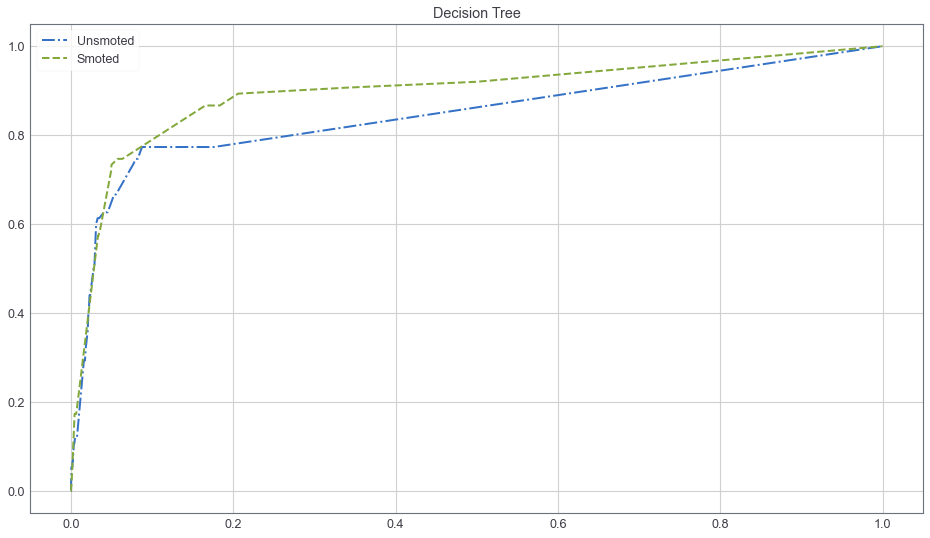

In [30]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf3, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf3, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Decision Tree")
plt.show()

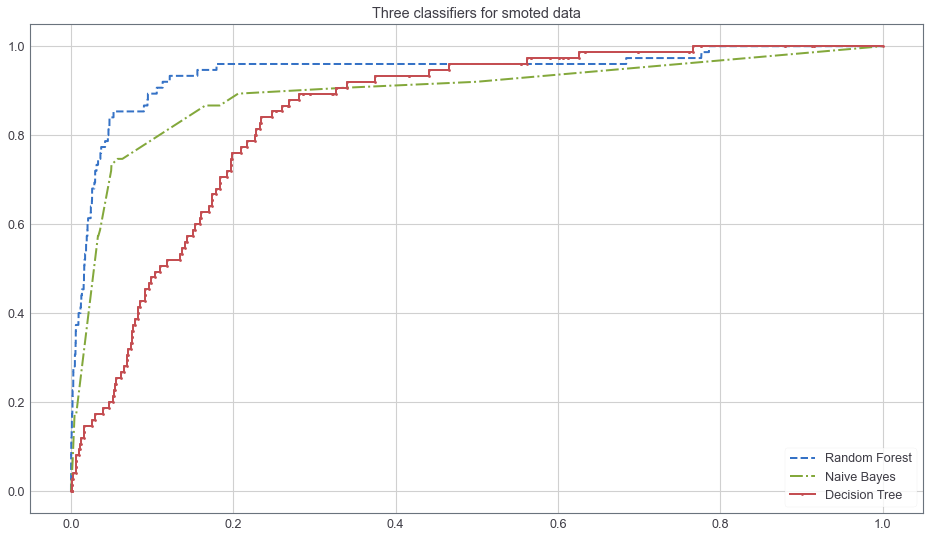

In [31]:
# draw three ROC curves of models trained by smoted trainset in one plot
plt.figure(figsize = (16,9))
smoted_fpr1, smoted_tpr1, smoted_auc1 = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr1, smoted_tpr1,"--", label='Random Forest', linewidth=2)

smoted_fpr2, smoted_tpr2, smoted_auc2 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"-.", label='Naive Bayes', linewidth=2)

smoted_fpr3, smoted_tpr3, smoted_auc3 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr3, smoted_tpr3,".-", label='Decision Tree', linewidth=2)
plt.legend(['Random Forest', 'Naive Bayes', 'Decision Tree'])
plt.title("Three classifiers for smoted data")
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

The accurate of a classifier can be reflected by the area composed by the ROC curve and x-axis. Based on the three ROC curves of smoted data, we can see that Random Forest classifier performs best among the three classifies. 

### Is using SMOTE a good idea? Why (not)?

Yes. 

Considering that AUC values in all three classifiers when using smoted data for all the 3 classifiers used above and the area of smoted ROC curve expands when applying decision tree, we can say that smoting data before applying classifiers gives a better dataset to work with.

## Privacy task - Yuhang Tian
Rank swapping is for protecting the privacy of each sample in the data set. It will initially sort all samples according to a feature in ascending order. Then, every sample will switch its feature value with its neighbour within the swapping range which is predefined.

### Print ROC curves


#### Useful Columns Extraction

In [32]:
df_trial = df_new[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account', 'label'
    ]].copy()

#### NAN Modification

In [33]:
# - if "cardverificationcodesupplied" is not known, then change it to False
# - if "issuerCountry" is not known, then change it to 'ZZ'
# - if "shopperCountry" is not known, then change it to 'ZZ'

df_trial.loc[df_trial['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_trial.loc[df_trial['issuerCountry'].isna(),'issuerCountry'] = 'ZZ'
df_trial.loc[df_trial['shopperCountry'].isna(),'shopperCountry'] = 'ZZ'

print(np.where(df_trial.isna())[1]) #no NAN anymore

[]


#### Data Spliting

In [34]:
df_label = df_trial['label']
df_sample = df_trial[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account'
    ]]

x_train, x_test, y_train, y_test = train_test_split(df_sample, df_label, test_size=0.20, shuffle=True, random_state=42)

#### Resample


In [35]:
# Here we use the smote function in library imblearn.
def smote(X,y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [36]:
# Implementing smote for training set before swap ranking.
x_train_unswapped, y_train_unswapped = smote(x_train_unswapped, y_train)
print("After SMOTE:", np.unique(y_train_unswapped, return_counts=True))

After SMOTE: (array([0, 1], dtype=int64), array([189358, 189358], dtype=int64))


#### Rank Swapping


##### Implement the rank swapping algorithm.

In [37]:
def rank_swapping(df, columns, p=1):
    '''
    df: pandas dataframe
    columns: the string names of columns
    p: the swapping range p%
    replace: replace the original dataframe
    
    return: rank swapped dataframe 
    '''
    if p == 0:
        return df
    
    print("It will take "+str(p)+" neighbour(s) into consideration")
    print(str(columns) + " - Swapping Range:", str(np.round(100*p/len(df),4))+'%')
    
    df_ = df.copy()
    length = len(df_)
    
    for column in columns:
        df_.sort_values(by=column, inplace=True)
        df_.reset_index(drop=True, inplace=True)
        col_values = df_[column].copy()
        for current_index in range(0, length):
            swap_index = current_index + random.randint(-p,p)
            if swap_index > length - 1:
                swap_index = random.randint(current_index, length-1)
            elif swap_index < 0:
                swap_index = random.randint(0, current_index)
            df_.at[current_index, column], df_.at[swap_index, column] = col_values[swap_index], col_values[current_index]
            
    return df_

##### Apply rank swapping algorithm

In [38]:
# check several samples before sampling
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,114,7,8,1,102.63520,1,0,123705,31114,160263,23,8,0
1,65,96,122,1,117.32210,1,1,2173,89498,30314,784,8,2
2,33,40,47,1,36.72333,1,1,204188,204483,192658,1217,8,3
3,55,40,47,1,51.72300,1,1,58864,136516,195673,1217,8,3
4,9,40,47,1,32.12573,1,1,132837,5577,8567,1463,8,3


In [39]:
# - bin: card issuer identifier
# - mail_id: Email address
# - ip_id: Ip address
# - card_id: Card number
# - euroAmount: the cost in euro

x_train_swapped, y_train_swapped = x_train_unswapped.copy(), y_train_unswapped.copy()
x_train_swapped['temp_label'] = y_train_swapped.copy()
x_train_swapped = rank_swapping(x_train_swapped, ['bin', 'mail_id', 'ip_id', 'card_id'], p=100)
x_train_swapped = rank_swapping(x_train_swapped, ['euroAmount'], p=10)
y_train_swapped = x_train_swapped['temp_label'].copy()
x_train_swapped.drop(columns=['temp_label'], inplace=True)

It will take 100 neighbour(s) into consideration
['bin', 'mail_id', 'ip_id', 'card_id'] - Swapping Range: 0.0264%
It will take 10 neighbour(s) into consideration
['euroAmount'] - Swapping Range: 0.0026%


The rank swapping can be applied to all features or partial ones. In this part of lab, *bin*, *mail\_id*, *ip\_id*, *card\_id* and *euroAmount* will be ranked and swapped. Besides *euroAmount* which swapping distance is 10 - every sample will take its $\pm 10$ neighbours into consideration, the swapping distance of others is 100. Since *bin*, *mail\_id*, *ip\_id*, *card\_id* are less significant to influence the prediction (intuitively \& tested), the swapping range is wider than *euroAmount* which is more important. Some other categorical features, like *shopperCountry*, can be encoded then rank swapped, but it may break the original structure to some extent, so they will maintain the same.

In [40]:
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,114,7,8,1,102.63520,1,0,123705,31114,160263,23,8,0
1,65,96,122,1,117.32210,1,1,2173,89498,30314,784,8,2
2,33,40,47,1,36.72333,1,1,204188,204483,192658,1217,8,3
3,55,40,47,1,51.72300,1,1,58864,136516,195673,1217,8,3
4,9,40,47,1,32.12573,1,1,132837,5577,8567,1463,8,3


In [41]:
# check several samples after sampling
x_train_swapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,43,7,8,1,0.64147,1,0,108847,30132,6358,1025,8,0
1,31,7,8,1,0.64147,1,0,144676,203604,192917,915,4,0
2,109,7,8,1,0.64147,1,0,115988,20277,126838,919,8,0
3,78,7,8,1,0.64147,1,0,51248,10245,95101,2273,2,0
4,12,7,8,1,0.64147,1,0,88207,188772,49404,117,10,0


##### Train three classifiers using rank swapping/unswapping

In [42]:
# function for drawing ROC curves
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    # add 
    if (normalize):
        scaler_norm = Normalizer().fit(x_train)
        x_train = scaler_norm.transform(x_train)
        x_test = scaler_norm.transform(x_test)
    
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    
    return fpr, tpr, auc

###### Decision Tree

Unswapped AUC = 0.7977635053767985 Swapped AUC = 0.8424507214839541


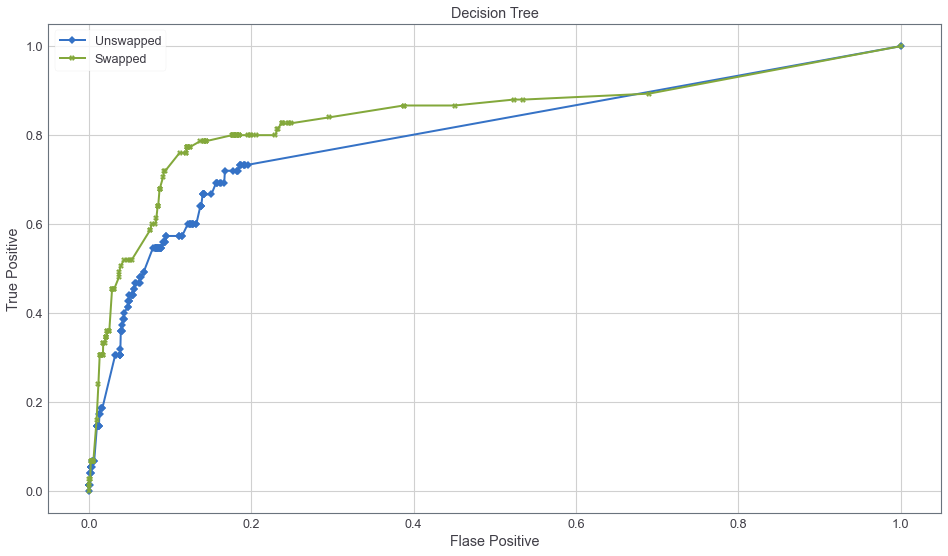

In [43]:
# constructing decision tree classifier
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of decision tree classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(dt, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of decision tree classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(dt, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Decision Tree")
plt.show()

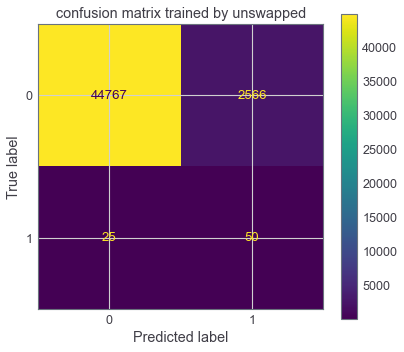

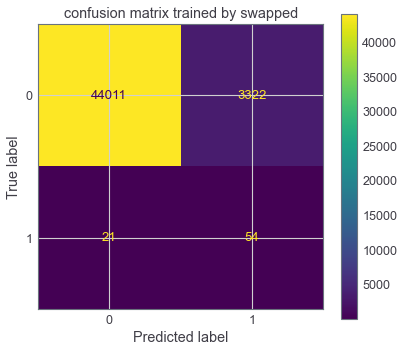

In [44]:
dt.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(dt, x_test, y_test)
plt.title('confusion matrix trained by unswapped')
# plt.savefig('./figures/privacy_DT_cm_unswapped.pdf', dpi=1200)
dt.fit(x_train_swapped, y_train_swapped)
plot_confusion_matrix(dt, x_test, y_test)
plt.title('confusion matrix trained by swapped')
# plt.savefig('./figures/privacy_DT_cm_swapped.pdf', dpi=1200)
plt.show()

###### Random Forest

Unswapped AUC = 0.9174557567306812 Swapped AUC = 0.9185182994246438


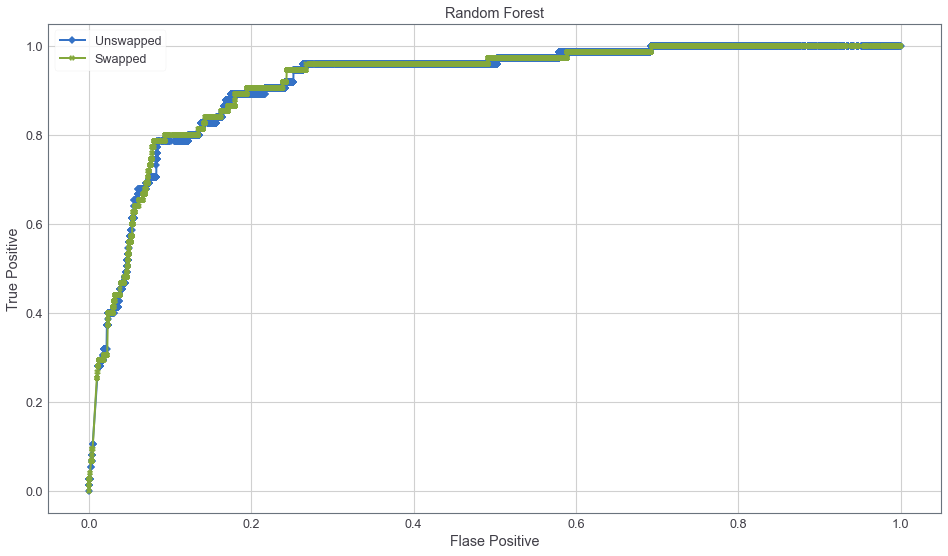

In [45]:
# constructing random forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of random forest classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(rf, x_train_unswapped, y_train_unswapped, x_test, y_test, normalize=False)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of random forest classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(rf, x_train_swapped, y_train_swapped, x_test, y_test, normalize=False)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Random Forest")
plt.show()

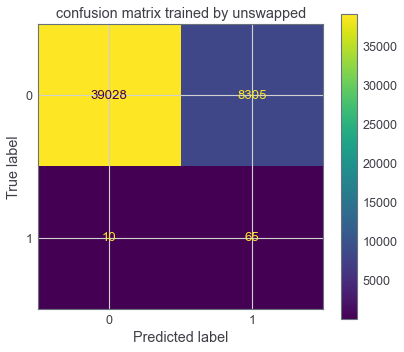

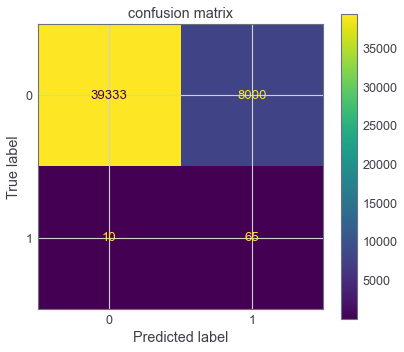

In [46]:
rf.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(rf, x_test, y_test)
plt.title('confusion matrix trained by unswapped')
# plt.savefig('./figures/privacy_RF_cm_unswapped.pdf', dpi=1200)
rf.fit(x_train_swapped, y_train_swapped)
plot_confusion_matrix(rf, x_test, y_test)
plt.title('confusion matrix trained by swapped')
# plt.savefig('./figures/privacy_RF_cm_swapped.pdf', dpi=1200)
plt.title('confusion matrix')
plt.show()

######  GaussianNB

Unswapped AUC = 0.8421162120860006 Swapped AUC = 0.842166775822365


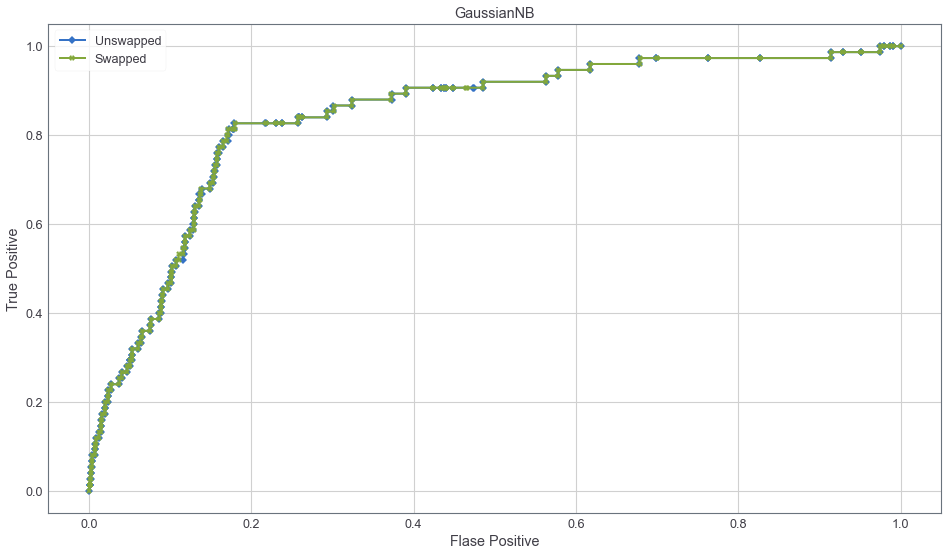

In [47]:
# constructing Gaussian NB classifier
nb = GaussianNB()
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of Gaussian NB classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(nb, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of Gaussian NB classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(nb, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("GaussianNB")
plt.show()

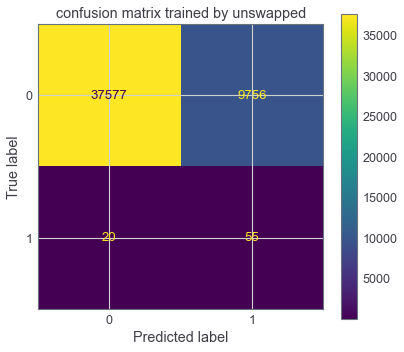

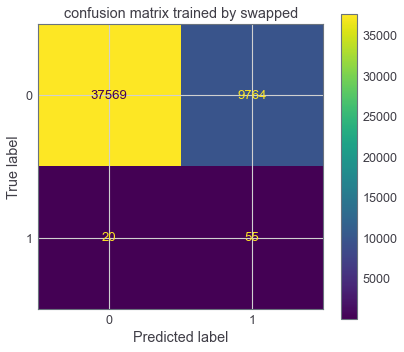

In [48]:
nb.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(nb, x_test, y_test)
plt.title('confusion matrix trained by unswapped')
# plt.savefig('./figures/privacy_GNB_cm_unswapped.pdf', dpi=1200)
plt.show()
nb.fit(x_train_swapped, y_train_swapped)
plot_confusion_matrix(nb, x_test, y_test)
plt.title('confusion matrix trained by swapped')
# plt.savefig('./figures/privacy_GNB_cm_swapped.pdf', dpi=1200)
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

According to the generated confusion matrices,

- true-positive rate (fraudulent cases detected rate):
    Random Forest > Gaussian Naive Bayes $\geq$ Decision Tree
- false-negative rate (benign cases misclassified rate):
    Decision Tree < Random Forest < Gaussian Naive Bayes
    
When evaluating a model, it is quite important which metrics used for determining its performance. We don't want any fraudulent cases escaping from our detection, so we use the precision rate to evaluate the performance:

Random Forest > Gaussian Naive Bayes $\geq$ Decision Tree

### Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

There is no significant influence on the performances of different classifiers when rank swapping is applied. However, rank swapping can, to some extent, shuffle the positions and hide the relationships of original data which contributes to the privacy protection. In conclusion, rank swapping aims at protecting data's privacy without affecting the model performance too much. It is advisable to use it.  

## Classification task

### Print relevant plots and metrics with clear headings.

In [49]:
# implementing k-fold cross validation function
def k_fold_validation(X, y, model, scoring='precision', k_flod=10):
    cv = KFold(n_splits=k_flod, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    max_score_index = np.argmax(scores['test_score'])
    
    return scores['test_score'][max_score_index], scores['estimator'][max_score_index] 

#### White Box - Decision Tree
White-box classifier can explain the decision step by step.

In [50]:
# Constructng the white-box classifier: decision tree
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
# Implementing k-fold cross validation before applying the classifier
dt_max_score, dt_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=dt)

<Figure size 1152x648 with 0 Axes>

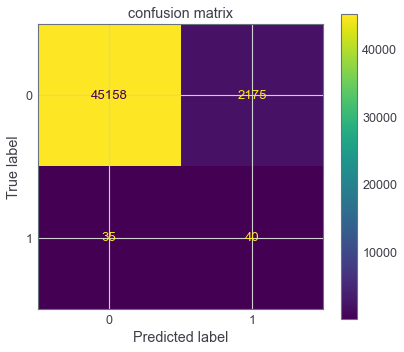

In [51]:
# Ploting confusion matrix of classifier's results
plt.figure(figsize=(16,9))
plot_confusion_matrix(dt_estimator, x_test, y_test)
plt.title('confusion matrix')
plt.show()

In [52]:
# select the the fraud cases in test set
x_test_fraud = x_test.iloc[np.where(y_test==1)[0], :]
y_pred = dt_estimator.predict(x_test_fraud)

In [53]:
# select the true positive results in fraud cases
x_test_TP = x_test_fraud.iloc[np.where(y_pred==1)[0], :]
# select the false positive results in fraud cases
x_test_FP = x_test_fraud.iloc[np.where(y_pred==0)[0], :]

In [54]:
x_test_TP[:]

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
27986,113,7,8,1,208.477750,1,0,157424,10325,207556,915,10,0
27993,116,7,8,1,346.393800,1,0,69591,20049,156595,2086,2,0
119,6,76,98,1,24.888930,1,0,101992,6769,51488,1301,6,1
33,47,76,98,1,34.977910,1,0,19627,187822,165746,1781,2,1
70,77,76,98,1,58.324310,1,0,199232,194664,192722,1299,9,1
151,27,76,98,1,275.070620,1,0,178870,188470,169925,149,6,1
27934,56,17,21,1,102.635200,1,0,3632,8523,40951,112,4,0
107,116,76,98,1,47.818430,1,0,198879,188439,48225,854,9,1
27919,37,7,8,1,118.671950,1,0,72921,130311,16982,2444,2,0
34,47,76,98,1,33.310310,1,0,203458,193431,200769,1300,10,1


In [55]:
x_test_FP[:]

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
58660,18,40,47,1,127.008700,1,1,44453,19721,76863,1474,10,3
27969,93,7,8,1,279.039450,1,0,163524,103359,205062,340,8,0
117,4,76,98,1,72.874120,1,0,8077,7222,192188,1489,10,1
58648,87,40,47,1,82.699330,1,1,180818,75614,75745,1474,10,3
129,11,76,98,1,54.155310,1,0,196132,196616,70073,2411,2,1
27975,105,7,8,1,128.294000,1,0,114052,39284,210501,221,12,0
12,31,76,98,1,49.986310,1,0,203705,193306,142105,1494,9,1
27944,65,7,8,1,69.599495,1,0,167282,169950,140586,916,10,0
120,6,76,98,1,37.437620,1,0,81794,196469,22516,2364,2,1
58645,59,40,47,1,49.711550,1,1,62297,157746,203787,1355,8,3


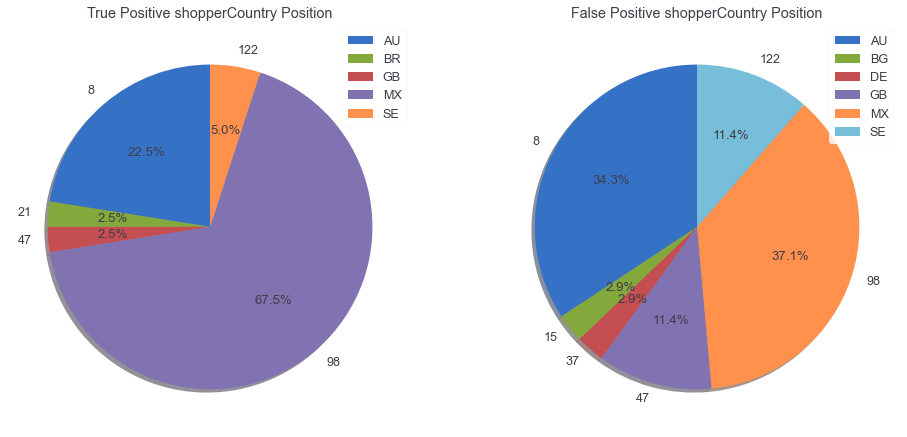

In [56]:
# Plotting the pie chart of TP and FP results to analyze the process of classifier
# Ploting pie chart of feature - 'shopperCountry' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['shopperCountry'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['shopperCountry'], return_counts=True)

pie_tp_label = []
for i in pie_TP_params[0]:
    pie_tp_label.append(list(df_new[df_new['shopperCountry'] == i].shoppercountrycode)[0])
pie_fp_label = []
for i in pie_FP_params[0]:
    pie_fp_label.append(list(df_new[df_new['shopperCountry'] == i].shoppercountrycode)[0])

# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(pie_tp_label)
plt.title('True Positive shopperCountry Position')
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(pie_fp_label)
plt.title('False Positive shopperCountry Position')
# plt.savefig("./figures/pie_shopperCountry.pdf", pdi=1200)
plt.show()

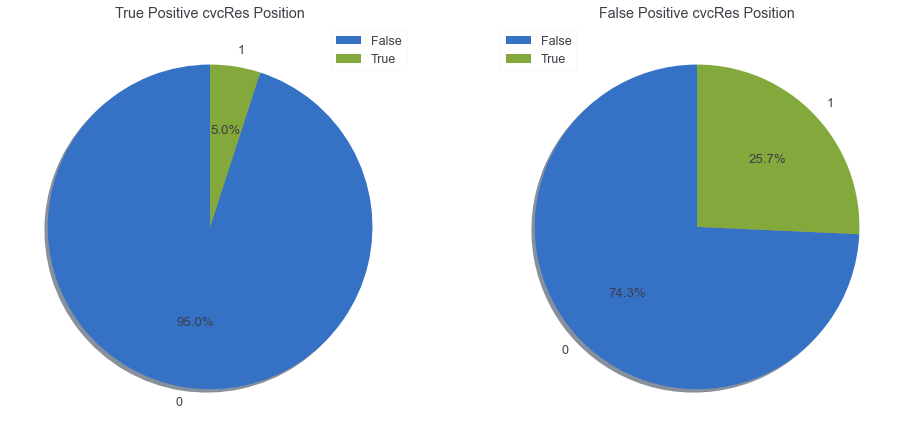

In [57]:
# Ploting pie chart of feature - 'cvcRes' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['cvcRes'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['cvcRes'], return_counts=True)
# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('True Positive cvcRes Position')
plt.legend([str(bool(pie_TP_params[0][0])), str(bool(pie_TP_params[0][1]))])
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('False Positive cvcRes Position')
plt.legend([str(bool(pie_FP_params[0][0])), str(bool(pie_FP_params[0][1]))])
# plt.savefig("./figures/pie_cvcRes.pdf", pdi=1200)
plt.show()

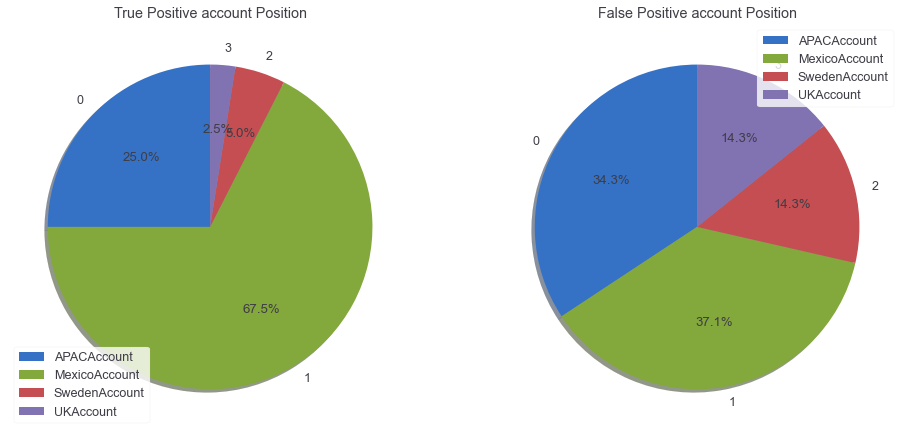

In [58]:
# Ploting pie chart of feature - 'account' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['account'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['account'], return_counts=True)

pie_tp_label = []
for i in pie_TP_params[0]:
    pie_tp_label.append(list(df_new[df_new['account'] == i].accountcode)[0])
pie_fp_label = []
for i in pie_FP_params[0]:
    pie_fp_label.append(list(df_new[df_new['account'] == i].accountcode)[0])

# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('True Positive account Position')
plt.legend(pie_tp_label)
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('False Positive account Position')
plt.legend(pie_fp_label)
# plt.savefig("./figures/pie_account.pdf", pdi=1200)
plt.show()

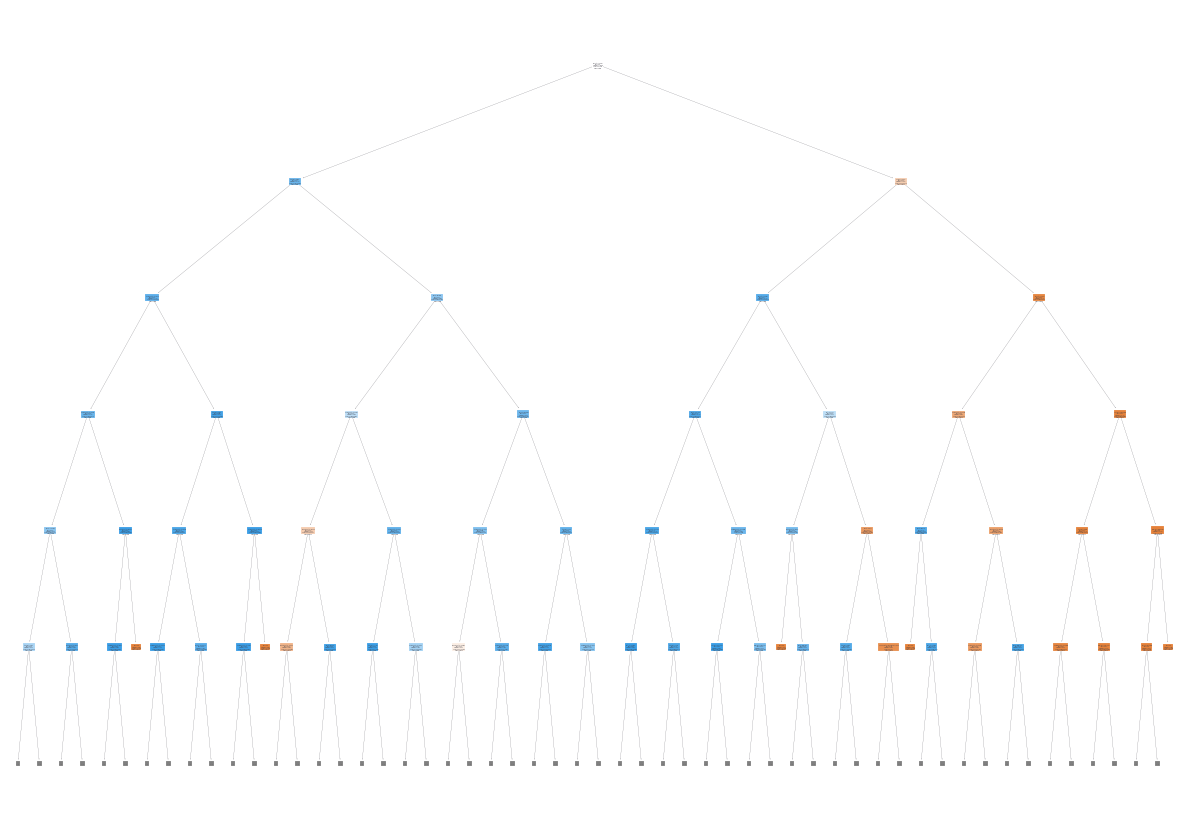

In [59]:
# Plot the first three layers of decision tree to have a brief look at its decision process
plt.figure(figsize=(21,15))
feature_names = x_train_unswapped.columns
class_names = ['benign', 'fraud']
plot_tree(dt_estimator, max_depth=5, filled=True, feature_names=feature_names, class_names=class_names, proportion=True)
# plt.savefig('./figures/Dtree.pdf', dpi=1200)
plt.show()

#### Black-box: Random Forest

In [60]:
# Constructing Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
# Implementing k-fold cross validation before applying classifier
rf_max_score, rf_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=rf)

<Figure size 1152x648 with 0 Axes>

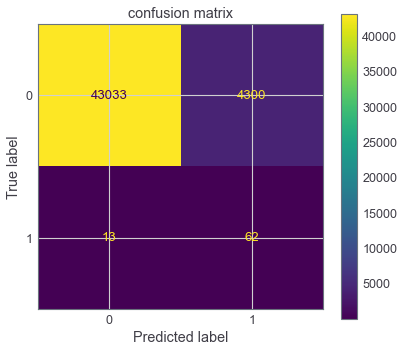

In [61]:
# Plotting confusion matrix for the black-box classifier after k-fold cross validation
plt.figure(figsize=(16,9))
plot_confusion_matrix(rf_estimator, x_test, y_test)
plt.title('confusion matrix')
plt.show()

### Evaluation
- Compare the performance of the two algorithms, focusing on performance criteria  that are relevant in practice. 
- Explain when your white-box classifier predicts transactions as fraudulent.



Based on the confusion matrix result, black-box classifier(Random Forest) performs better than the white-box classifier(Decision Tree) as it finds more fraud cases in the same test set. 


## Bonus task

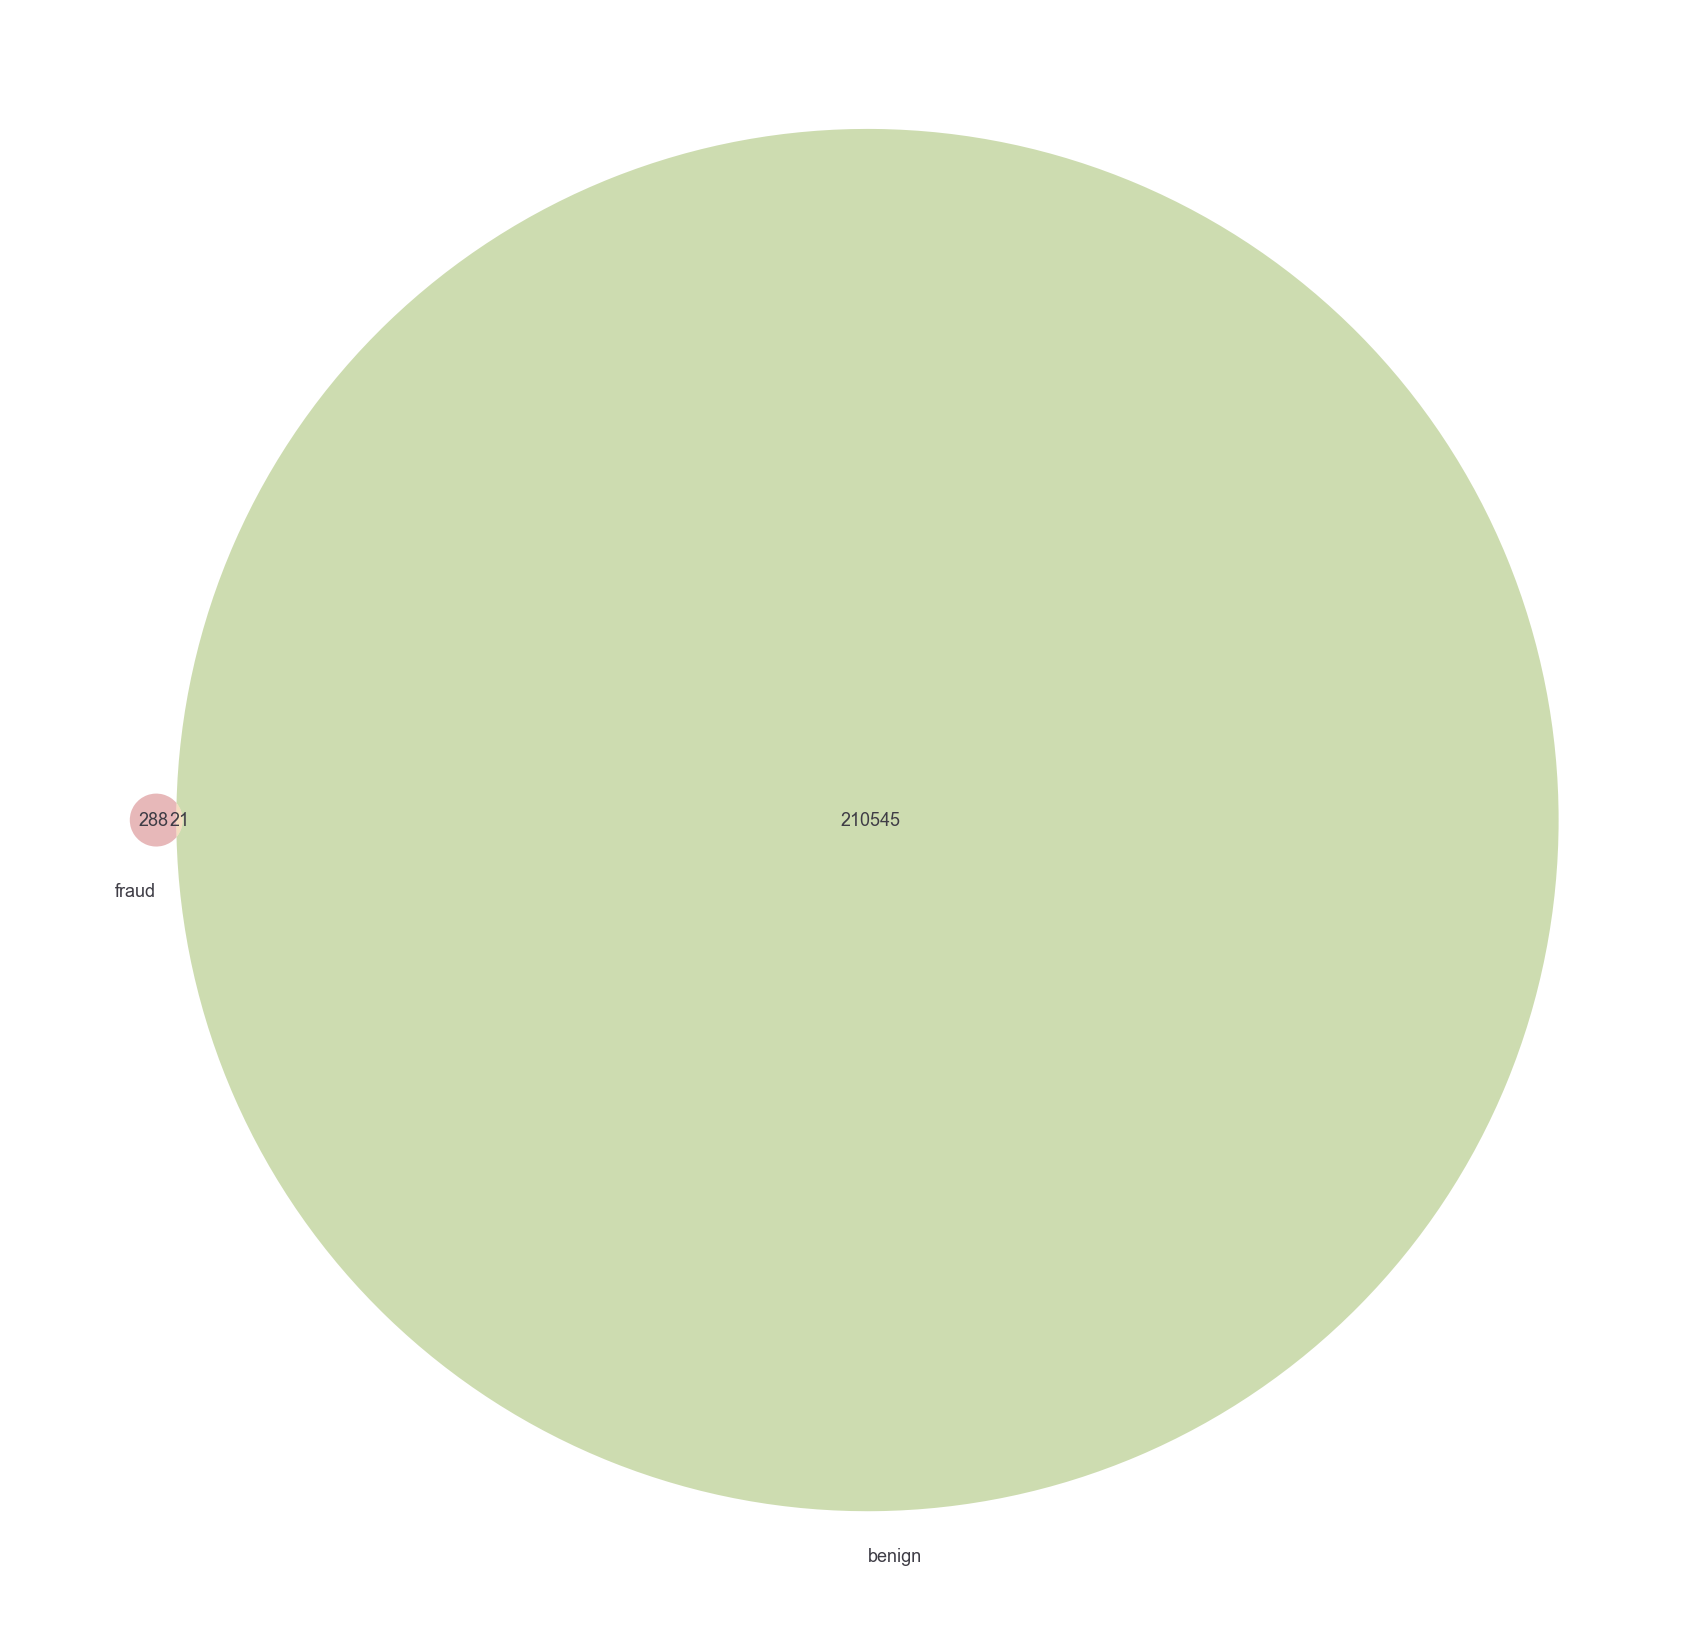

In [62]:
# plot the overlap of two dataframe
plt.figure(figsize=(30, 30))
# current our aggregate dataframe is unsomted and unswapped
df_aggregate = df_new[[
    'shopperCountry', 'issuerCountry', 'interaction', 'euroAmount',
    'cardverificationcodesupplied', 'cvcRes', 'card_id', 'txCode', 'account', 
    'label'
]].copy()

df_aggregate_fraud = df_aggregate[df_aggregate['label'] == 1]
df_aggregate_benign = df_aggregate[df_aggregate['label'] == 0]

out = venn2([
    set(df_aggregate_fraud['card_id'].values),
    set(df_aggregate_benign['card_id'].values)
], set_labels=('fraud', 'benign'))
for text in out.set_labels:
    text.set_fontsize(18)
for text in out.subset_labels:
    text.set_fontsize(18)
plt.show()

### Data Splitting

In [65]:
df_agg_label = df_new['label']
df_agg_sample = df_new[[
    'shopperCountry', 'issuerCountry', 'interaction', 'euroAmount',
    'cardverificationcodesupplied', 'cvcRes', 'card_id', 'txCode', 'account'
]]

x_train, x_test, y_train, y_test = train_test_split(
    df_agg_sample, df_agg_label, test_size=0.20, shuffle=True, random_state=42)

The following cell will cost you about 30 minutes to run, so we suggest you to use the generated one - df_aggregated.csv. In order to save you time, we comment the following cell.  

In [66]:
def aggregate_feature(df):
    shopperCountry = []
    issuerCountry = []
    interaction = []
    euroAmount_mean = []
    euroAmount_var = []
    cardverificationcodesupplied = []
    cvcRes = [] 
    txCode = [] 
    account = [] 
    label = []
    card_id = np.unique(df['card_id'])
    for i in card_id:
        
        
        # take mode of shopperCountry
        shopperCountry.append(np.argmax(np.bincount(df[df['card_id'] == i].shopperCountry)))
        
        # issuerCountry (identical for one card_id)
        issuerCountry.append(np.argmax(np.bincount(df[df['card_id'] == i].issuerCountry)))
        
        # take meam of interaction
        interaction.append(df[df['card_id'] == i].interaction.mean())
        
        # take mean of euroAmount
        euroAmount_mean.append(df[df['card_id'] == i].euroAmount.mean())
        
        # take variance of euroAmount
        euroAmount_var.append(df[df['card_id'] == i].euroAmount.std())
        
        # take mean of cardverificationcodesupplied
        cardverificationcodesupplied.append(df[df['card_id'] == i].cardverificationcodesupplied.mean())
        
        # take mean of cvcRes
        cvcRes.append(df[df['card_id'] == i].cvcRes.mean())
        
        # take mode of txCode (identical)
        txCode.append(np.argmax(np.bincount(df[df['card_id'] == i].txCode)))
        
        # take mode of account (identical)
        account.append(np.argmax(np.bincount(df[df['card_id'] == i].account)))
        
        # take maximum of label (identical)
        label.append(df[df['card_id'] == i].label.max())
        
    df_ = pd.DataFrame()
    df_['card_id'] = card_id
    df_['shopperCountry'] = shopperCountry
    df_['issuerCountry'] = issuerCountry
    df_['interaction'] = interaction
    df_['euroAmount_mean'] = euroAmount_mean
    df_['euroAmount_var'] = euroAmount_var
    df_['cardverificationcodesupplied'] = cardverificationcodesupplied
    df_['cvcRes'] = cvcRes
    df_['txCode'] = txCode
    df_['account'] = account
    df_['label'] = label
    
    return df_

In [67]:
df_agg_feature = aggregate_feature(pd.concat([x_train, y_train], axis=1))
df_agg_feature.to_csv('./df_aggregated.csv')

KeyboardInterrupt: 

In [ ]:
df_agg_feature = pd.read_csv('./df_aggregated.csv')

### NAN Modification

In [ ]:
df_agg_feature.loc[df_agg_feature['euroAmount_var'].isna(),'euroAmount_var'] = 0

### Resample


In [ ]:
x_train = df_agg_feature['shopperCountry', 'issuerCountry', 'interaction', 'euroAmount_mean', 'euroAmount_var',
    'cardverificationcodesupplied', 'cvcRes', 'card_id', 'txCode', 'account'].copy()
y_train = df_agg_feature['label']

### Plot ROC

In [ ]:
rf.fit(x_train_smoted, y_train_smoted)
plot_confusion_matrix(rf, x_test, y_test)
plt.title('confusion matrix')
plt.show()

The aggregation maintains the ability to find the true positive - real fraudulent cases, but it significantly reduces the false negative - misclassified benign cases. 